# Approche non modale de la stabilité dans un écoulement de Poiseuille

## Introduction et motivation

Dans les notebooks précédents, nous avions étudié l'équation d'Orr-Sommerfeld que nous avions discrétisée et ramenée à un problème aux valeurs propres généralisé $A\hat v = Bc \hat v$ en considérant des modes propres de la forme $\hat v = v(y)\, e^{i\alpha (x-ct)}$.
 
Nous pouvons ramener ce problème aux valeurs propres à une équation d'évolution pour les modes propres. En effet, nous observons que

$$ \partial_t \hat v = -i\alpha c \hat v   \qquad   B^{-1}A \hat v = c \hat v $$

Et donc 

$$ \partial_t \hat v = M \hat v   \qquad M = -i\alpha B^{-1}A$$

Dans le notebook précédant, nous avions discuté de la stabilité de l'écoulement en observant la partie imaginaire des valeurs propres de l'opérateur $M$. Dans ce notebook, nous allons effectuer une analyse plus détaillée de l'évolution des perturbations. Nous nous limiterons plus à étudier le comportement des modes propres, car une telle analyse est incomplète étant donné la nature non linéaire des équations de Navier-Stokes. 

L'inconvénient de l'étude modale de la stabilité vient de la non orthogonalité des vecteurs propres de l'opérateur $M$. En effet, la matrice $M$ n'est pas hermitienne et il est donc possible que ces vecteurs propres soient non orthogonaux. Cela a pour conséquence qu'une combinaison linéaire de deux vecteurs propres, i.e. dont la norme diminue dans le temps, peut voir sa norme grandir avec le temps, pendant un temps fini. Le problème posé par cette croissance temporaire de certaines perturbations est que si celle-ci devient trop importante, l'approximation linéaire des équation de Navier-Stokes sur laquelle repose l'équation d'Orr-Sommerfeld n'est plus valable et la perturbation considérée, composée que de mode stables *selon l'équation d'Orr-Sommerfeld*, pourrait devenir instable.

Il est donc nécessaire de déterminer quelles sont les croissances maximales que l'on peut obtenir avec des combinaisons linéaires des modes stables afin de vérifier si celles-ci ne sont pas trop grandes pour engendrer des instablilités. Ce travail s'effectue typiquement par une décomposition en valeurs singulières (svd), qui va chercher l'élongaltion et la direction d'élongation maximale de la boule unité sous une transformation linéaire.

## Implémentation et test de la svd

In [1]:
import numpy,scipy,scipy.linalg,time
import matplotlib.pyplot as pyplot
from matplotlib import rcParams, cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Importons les fonctions que nous avons défini afin de construire les opérateurs nécessaires.

In [2]:
import operateurs

In [3]:
N = 401 
alpha = 0.6
Re = 10000
t = 1

[A,B] = operateurs.buildAB_forward(Re, alpha, N)

Calculons l'exponentielle $e^{Mt}$ à partir de la décomposition en valeurs et vecteurs propres de M.

In [4]:
start = time.time()

[c,vecp] = scipy.linalg.eig(A,B)
c = -1j*alpha*c # pour avoir les valeurs propres de M = -i*alpha*B^-1*A
vecp_inv = numpy.linalg.inv(vecp)

D = scipy.eye(N-4) * numpy.exp(c*t)
expMt = numpy.dot( numpy.dot( vecp , D) , vecp_inv )

print(time.time()-start)
print(expMt[:2,:2])

2.849517345428467
[[-0.04796193+0.00102805j  0.00146956+0.00067164j]
 [-0.10054344+0.00208506j -0.00372828+0.00150026j]]


Vérifions le calcul de l'exponentielle avec sa série de Taylor. Cette vérification ne fonctionne que pour des temps suffisament petits. Autrement, la série ne converge pas assez vite. <Notons que cette méthode n'est pas utile pour calculer précisément l'exponentielle d'une matrice à cause du fait qu'elle requiert la manipulation de très petits (ou très grands) nombres par la présence de la factorielle.>

In [5]:
#expMt_taylor = scipy.eye(N)
#Mit = scipy.eye(N)
#
#for i in range(1,10):
#    
#    Mit = numpy.dot(Mit,M)*t
#    expMt_taylor = expMt_taylor + 1/numpy.math.factorial(i)*Mit
#    
#print(expMt_taylor[:2,:2])

Nous faisons ensuite le calcul de la svd

In [6]:
u,s,v = scipy.linalg.svd(expMt)
print(s[:5])

[ 5.27193368  3.1653444   1.18171657  1.14802061  1.06273988]


Nous implémentons le calcul de la svd pour plusieurs points de temps dans des fichiers séparés que nous importons dans la suite de ce notebook.

In [7]:
import svd

In [8]:
N = 401
alpha = 0.6
Re = 10000
t_vec = numpy.linspace(0,100,30)

[A,B] = operateurs.buildAB(Re, alpha, N)
#M = -1j*alpha*numpy.dot(numpy.linalg.inv(B), A)

start = time.time()
s = svd.svd_scipy_exp_eig_A_B(A, B, alpha, t_vec)
print("Temps d'exécution: {:.3f} secondes".format(time.time()-start))

# valeurs singulières max pour chaque t
print("Valeurs singulières: ")
print(s[:,1])

Il n'y a pas de modes instables ni stationnaires
Temps d'exécution: 13.618 secondes
Valeurs singulières: 
[  1.           3.40263281   5.09059293   7.64281806  10.88948331
  14.62445072  18.52886516  22.20956509  25.2578858   27.31530489
  28.13541109  27.62960704  25.88561922  23.15352249  19.80168833
  16.25219686  12.90901457  10.0896857    7.96188161   6.49428784
   5.4943794    4.75793249   4.16842945   3.68073307   3.27333673
   2.92532697   2.61814398   2.34136742   2.09156957   1.86734053]


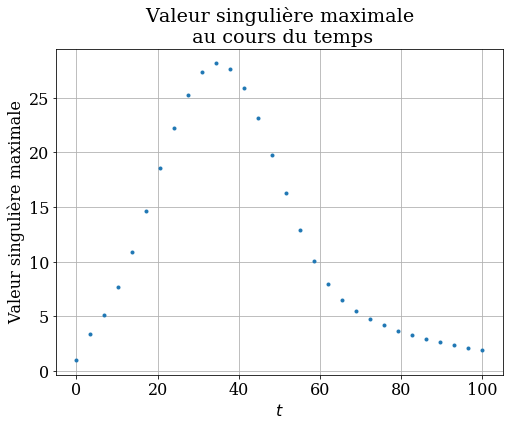

In [9]:
pyplot.figure(figsize=(8,6));
pyplot.plot(t_vec, s[:,1], '.');
pyplot.title('Valeur singulière maximale\n au cours du temps');
pyplot.xlabel('$t$');
pyplot.ylabel('Valeur singulière maximale');
pyplot.legend(loc=1);
pyplot.grid();
pyplot.show();

Nous évitons de calculer l'exponentielle de $M$ à partir de sa décomposition en modes propres car cette dernière n'est pas correctement réalisée par l'ordinateur, probablement à cause de l'inversion de la matrice $B$ qui comporte des nombres très petits. Les décompositions respectives avec $M$ d'une part et $A,B$ de l'autre sont réalisées ci-dessous.

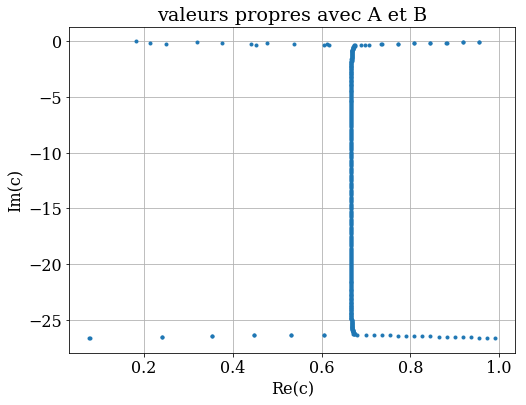

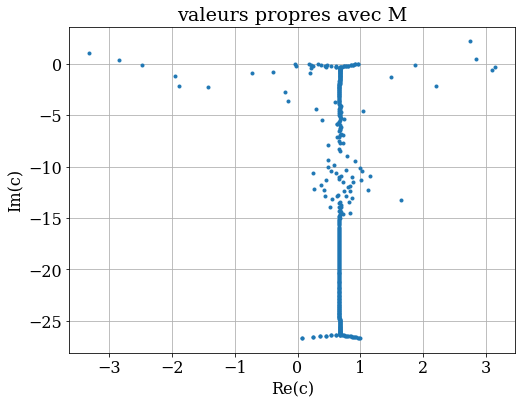

In [10]:
N = 401
alpha = 0.6
Re = 10000
t_vec = numpy.linspace(0,0.5,10)

[A,B] = operateurs.buildAB(Re, alpha, N)
M = numpy.dot(numpy.linalg.inv(B), A) 

# Décomposition en valeur et vecteur propres avec A et B
[c,vecp] = scipy.linalg.eig(A,B)

pyplot.figure(figsize=(8,6));
pyplot.plot(numpy.real(c), numpy.imag(c), '.');
pyplot.title('valeurs propres avec A et B');
pyplot.xlabel('Re(c)');
pyplot.ylabel('Im(c)');
pyplot.legend(loc=1);
pyplot.grid();
pyplot.show();

# Décomposition en valeur et vecteur propres de M
[c,vecp] = scipy.linalg.eig(M)

pyplot.figure(figsize=(8,6));
pyplot.plot(numpy.real(c), numpy.imag(c), '.');
pyplot.title('valeurs propres avec M');
pyplot.xlabel('Re(c)');
pyplot.ylabel('Im(c)');
pyplot.legend(loc=1);
pyplot.grid();
pyplot.show();